This jupyter notebook shows the code used for the analysis:  
1. Proportion analysis using `statsmodels` implementaiton of MixedLM;
2. Differential gene expression analysis using pydeseq2.

In [62]:
# libraries to work with single-cell data and tables
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import os

# for proportion analysis
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import forestplot as fp

# for differential gene expression
import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import adjustText
from adjustText import adjust_text
import decoupler as dc

# for visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.rcdefaults()
sc.set_figure_params({'facecolor':'white'})
plt.rcParams['axes.grid'] = False
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['figure.dpi'] = 100

In [66]:
# list versions of used packages
{'scanpy': sc.__version__, 
 'pandas': pd.__version__, 
 'numpy': np.__version__,
 'anndata': anndata.__version__,
 'forestplot': fp.__version__,
 'pydeseq2': pydeseq2.__version__,
 'decoupler': dc.__version__,
 'adjustText': adjustText.__version__,
 'seaborn': sns.__version__,
 'matplotlib': matplotlib.__version__
}

{'scanpy': '1.10.2',
 'pandas': '2.2.2',
 'numpy': '1.26.4',
 'anndata': '0.10.8',
 'forestplot': '0.4.1',
 'pydeseq2': '0.5.0',
 'decoupler': '1.8.0',
 'adjustText': '1.2.0',
 'seaborn': '0.13.2',
 'matplotlib': '3.9.2'}

# Read test data (part of the real dataset generated in this study with up to 100 cells per celltype)

In [20]:
adata = sc.read_h5ad('test_data/test.h5ad')
adata.uns['log1p'] = {'base':None}

`sample`: sample annotation  
`patient`: patient annotation  
`origin`: origin of biospecimen  
`type`: condition, e.g. aneurysm or normal (=mild aneurysm)  
`refined_annotation`: annotation

In [29]:
adata.obs.columns

Index(['sample', 'patient', 'origin', 'type', 'n_genes_by_counts',
       'total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'n_genes', 'total_counts_mt',
       'pct_counts_mt', 'low', 'labels_low', 'refined_annotation', 'c'],
      dtype='object')

In [26]:
adata[1,:].X.sum()

4107.397

In [27]:
adata.layers['counts'][1,:].sum()

1794.0

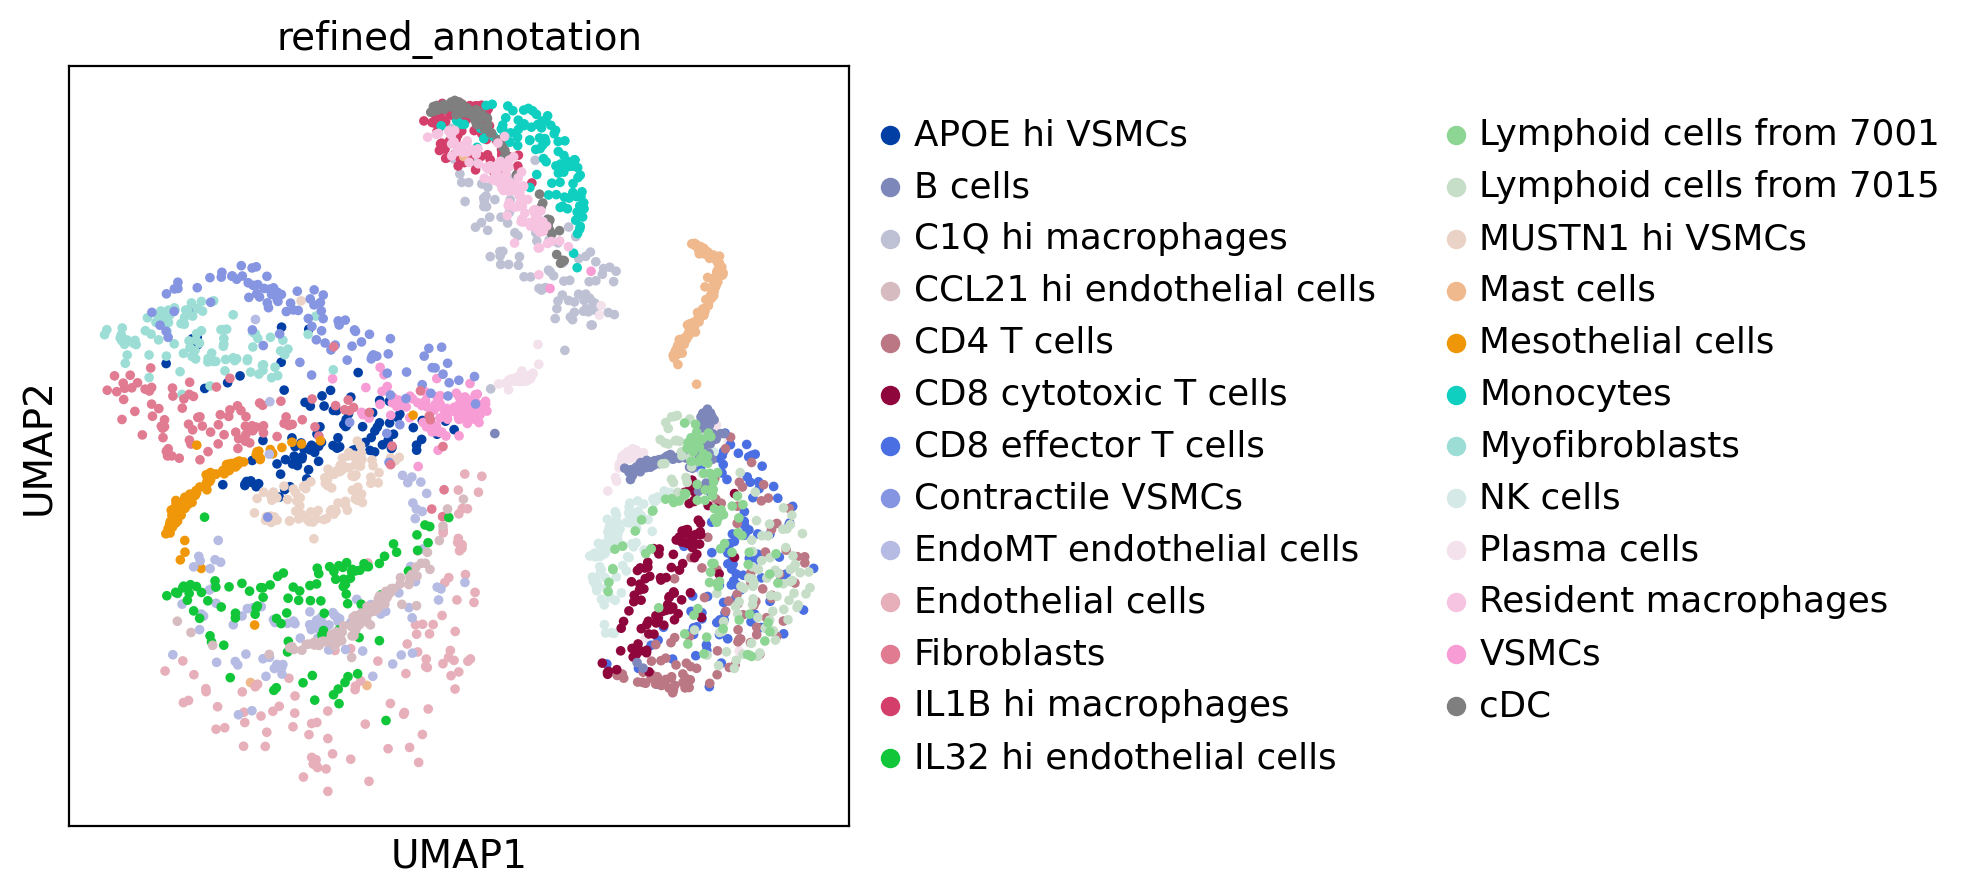

In [22]:
sc.pl.umap(adata, color=['refined_annotation'])

Real dataset had batch effect by sample. It was fixed using `sc.external.pp.bbknn` instead of `sc.pp.neighbors`.  
The example dataset is already normalized and log-transformed. It also has counts in `.layers['counts']`.

# Proportion analysis using `statsmodels` implementation of MixedLM

In [31]:
def generate_freq_table(adata: anndata.AnnData,
                        sample_col: str,
                        group_col: str,
                        condition_col: str) -> pd.DataFrame:

    # generate count table from .obs
    df = adata.obs
    df['c'] = [1]*df.shape[0]
    dfgr = df.groupby([sample_col,condition_col,group_col]).agg(
        {'c': 'sum',
         sample_col: 'first',
         condition_col: 'first',
         group_col: 'first'}
    )

    # calculate relative frequency of cell types in each sample
    res = []

    i_start = 0
    step = len(df[group_col].unique())
    
    numeric_cols = dfgr.select_dtypes(include='number').columns
    
    for i in range(i_start, dfgr.shape[0], step):
        subset = dfgr.iloc[i:i+step][numeric_cols]
        # print(subset.shape)
        s = subset.sum().sum()  
        i_start = i + step
        
        norm = subset.sum(axis=1)/s
        res.append(norm)

    resdf = pd.concat(res).reset_index()
    
    return resdf

In [32]:
freq=generate_freq_table(adata=adata,
                         sample_col='sample',
                         group_col='refined_annotation',
                         condition_col='type')

/tmp/ipykernel_430382/1224066.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfgr = df.groupby([sample_col,condition_col,group_col]).agg(


In [38]:
freq.columns=['patient','type','refined_annotation','c']

In [39]:
# either 0 or 1
freq[['type','patient','c']].groupby(['type','patient']).agg(sum).head()

/tmp/ipykernel_430382/1384002312.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq[['type','patient','c']].groupby(['type','patient']).agg(sum).head()
/tmp/ipykernel_430382/1384002312.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  freq[['type','patient','c']].groupby(['type','patient']).agg(sum).head()


c
type     patient                          
Aneurysm AMKO03_7005AscAortaPost_0_v1  1.0
         AMKO03_7006AscAortaAnt2_0_v1  1.0
         AMKO03_7008Aorta2_0_v1        0.0
         AMKO03_7011Aneurysm_0_v1      1.0
         AMKO03_7011Normal_0_v1        0.0

In [44]:
def calc_mixedlm(freq_table: pd.DataFrame,
                 group_col: str,
                 sample_col: str,
                 condition_col: str,
                 condition_ref: str,
                 condition_test: str):

    # calculate MixedLM for each cell type
    lme_res = []
    celltypes = freq_table[group_col].unique()
    
    for celltype in celltypes:
        resdf_tmp = freq_table[freq_table[group_col]==celltype]
        resdf_tmp['c'] = resdf_tmp['c'].fillna(0)
        formula = f'c~C({condition_col},Treatment(\'{condition_ref}\'))'
        md = smf.mixedlm(formula=formula, 
                         data=resdf_tmp, 
                         groups=resdf_tmp[sample_col])
        mdf = md.fit()

        aneurysm_effect = \
        f'C({condition_col}, Treatment(\'{condition_ref}\'))[T.{condition_test}]'
        resrow = \
        mdf.summary().tables[1]\
        .loc[aneurysm_effect, ['Coef.','[0.025','0.975]','P>|z|']]\
        .values.tolist()+[celltype]

        lme_res.append(pd.Series(resrow))

    lme_resdf = pd.concat(lme_res,axis=1).T
    lme_resdf.columns = ['coef','ci_2.5%','ci_97.5%','p-value','cell type']
    lme_resdf['p-value'] = lme_resdf['p-value'].astype(float)
    
    return lme_resdf

In [45]:
lme_resdf = \
calc_mixedlm(freq_table=freq,
             group_col='refined_annotation',
             sample_col='patient',
             condition_col='type',
             condition_ref='Normal',
             condition_test='Aneurysm')

<Axes: xlabel='MixedLM estimate (95% CI)'>

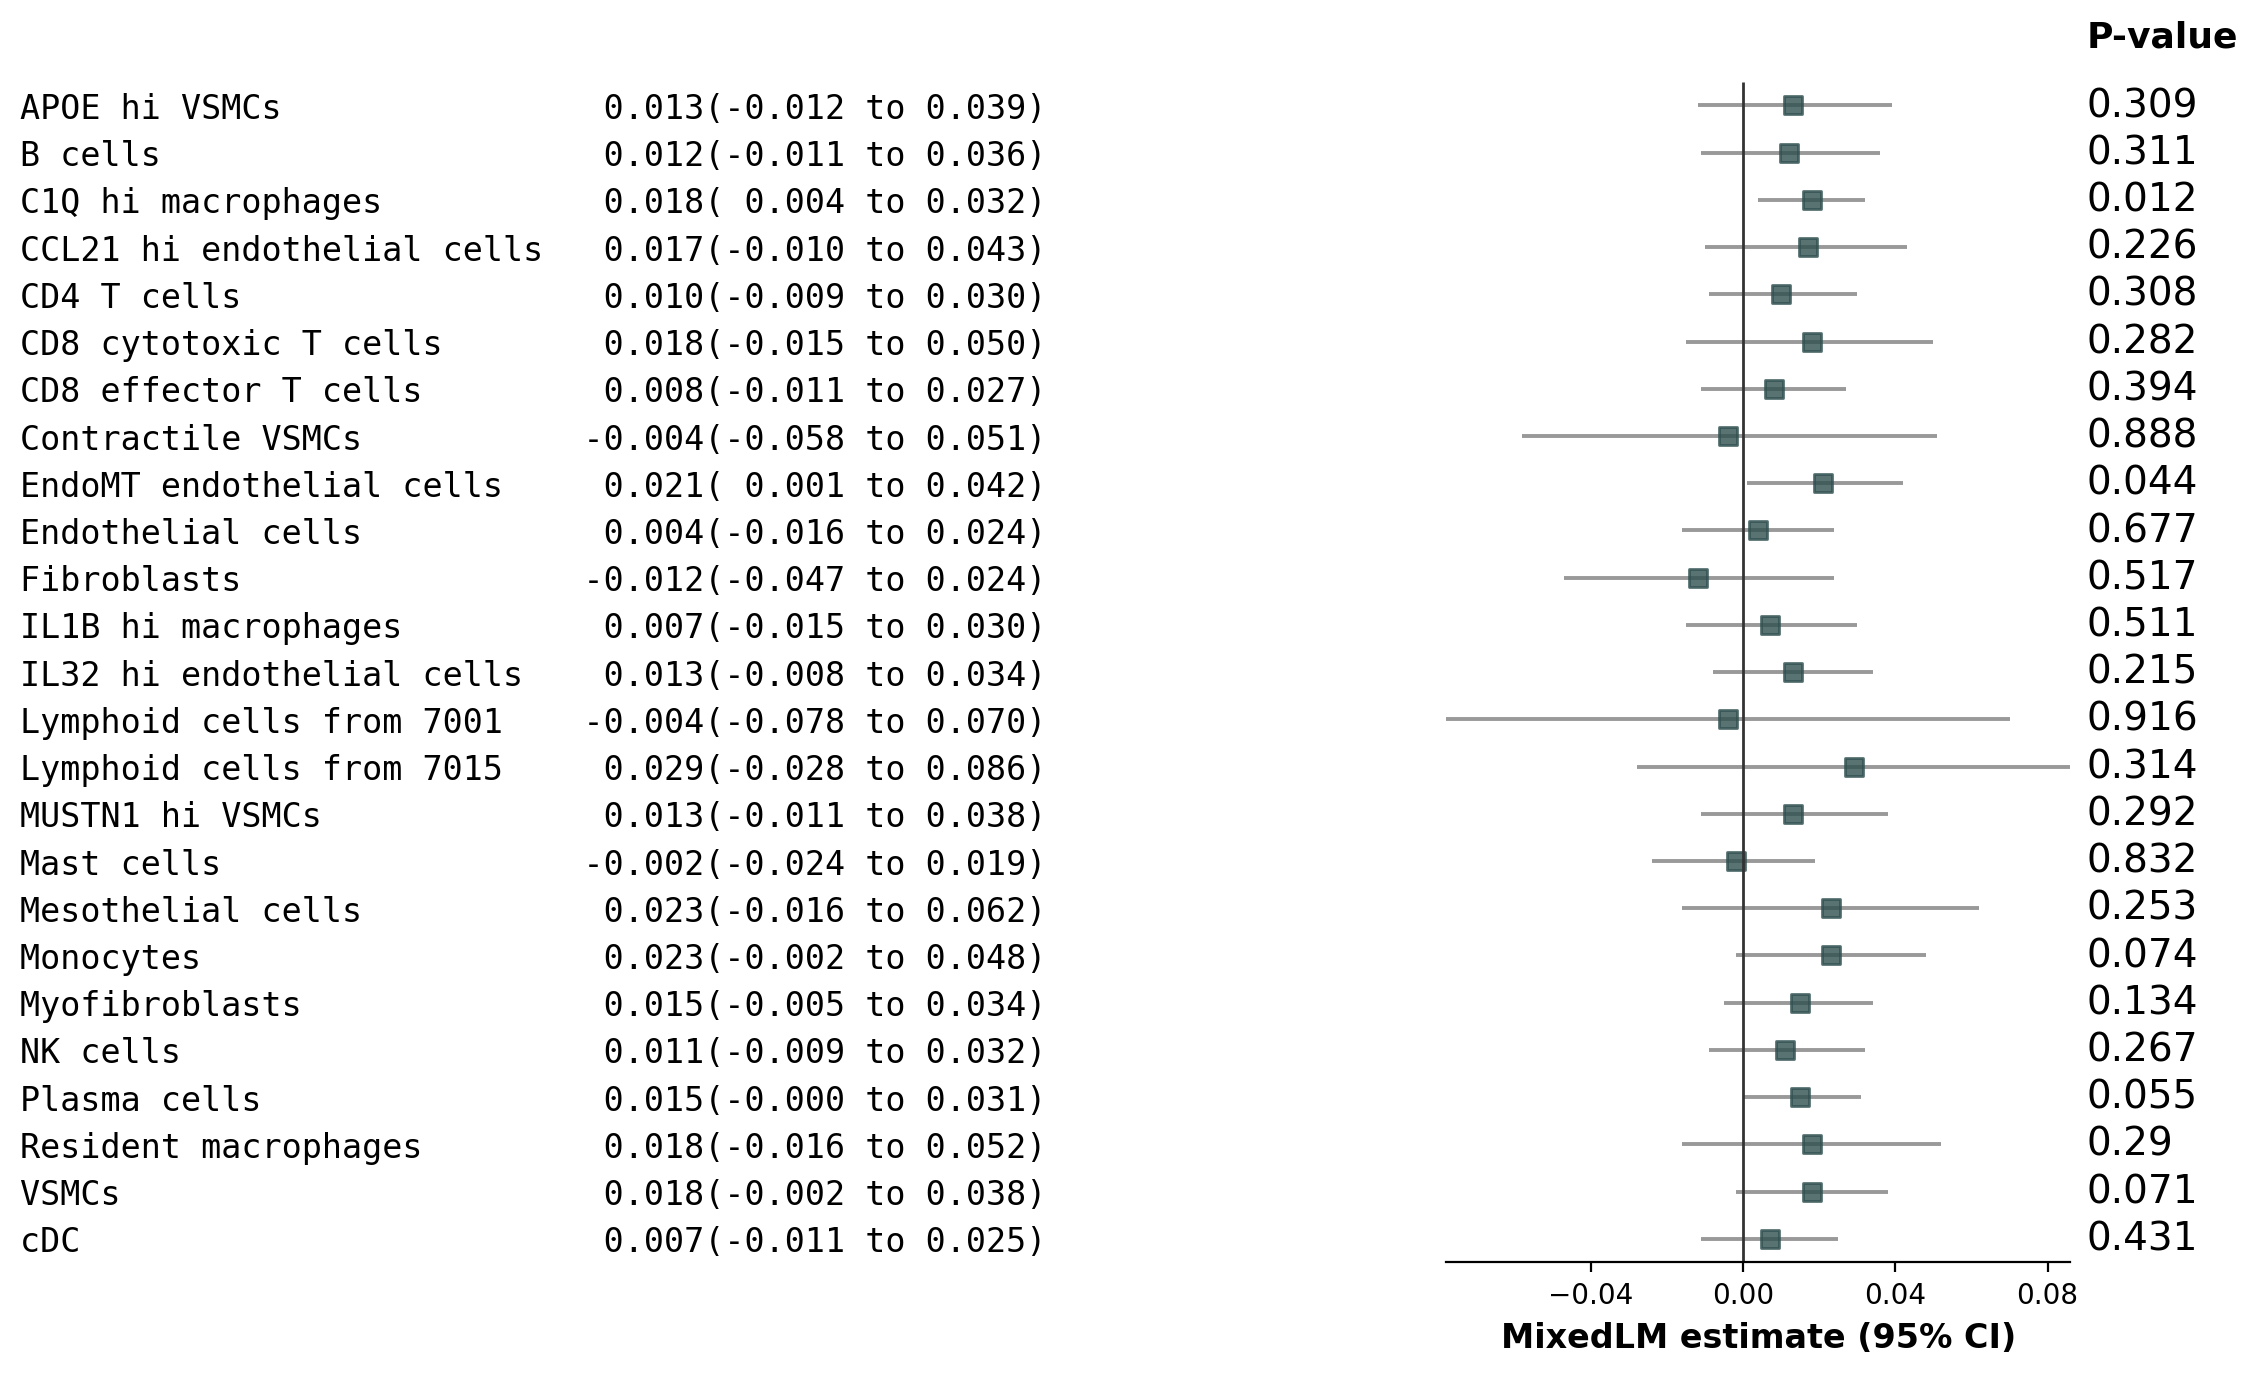

In [46]:
fp.forestplot(dataframe=lme_resdf,  
              estimate="coef",  
              ll="ci_2.5%", 
              hl="ci_97.5%", 
              pval='p-value',
              starpval=False,
              decimal_precision=3,
              varlabel="cell type",  
              xlabel="MixedLM estimate (95% CI)", 
              )

# Differential gene expression using pydeseq2

## Calculate and save .csv

In [194]:
def filter_cell_gene_matrix(adata: anndata.AnnData,
                            celltype_column: str
                            ) -> anndata.AnnData:

    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=0)
    adata=adata[:,adata.var['n_cells']/adata.shape[0]>0.05]

    print('Filtering out (1) cells with less than 200 genes, '\
          f'(2) genes expressed in less than 5 % of cells in {celltype_column}.')
    print(celltype_column, adata.shape)
    
    return adata
    

def calculate_pseudobulk(adata: anndata.AnnData,
                         celltype_column: str,
                         sample_column: str,
                         groups_column: str,
                         condition_ref: str,
                         condition_test: str,
                         output_folder: str,
                         skip_checks: bool=False,
                         save: bool=False
                         ) -> None:
    
    celltypes = adata.obs[celltype_column].unique()
    
    for celltype in celltypes:
        
        celltype_adata = adata[adata.obs[celltype_column]==celltype]
        celltype_adata = filter_cell_gene_matrix(celltype_adata, celltype)
        
        psb = dc.get_pseudobulk(adata=celltype_adata,
                                sample_col=sample_column,
                                groups_col=groups_column,
                                mode='sum',
                                min_cells=5,
                                min_prop=0,
                                min_smpls=0,
                                skip_checks=skip_checks)

        psb = psb[psb.obs[psb.obs.psbulk_n_cells!=0].index, :]
        
        if len(psb.obs[groups_column].unique())<2: 
            print(f'{celltype} is represented only in one group.')
            continue

        try:
            dds = DeseqDataSet(adata=psb,
                               design_factors=[groups_column],
                               ref_level=[groups_column,condition_ref],
                               quiet=False)
        except:
            try:
                psb.X = psb.X.astype(int)
                dds = DeseqDataSet(adata=psb,
                                   design_factors=[groups_column],
                                   ref_level=[groups_column,condition_ref],
                                   quiet=False)
            except Exception as e: 
                print(f'{celltype} is failed. {celltype_adata.shape}', e)
                continue
                
        try: dds.deseq2()
        except Exception as e: print(e); continue
        
        contrast = [groups_column, condition_test.replace('_','-'), 
                    condition_ref.replace('_','-')]
        stat_res = DeseqStats(dds=dds, contrast=contrast)
        stat_res.summary()
        res = stat_res.results_df

        print(f'Cell type = {celltype}, '\
              'number of significant (padj<0.05) gene findings='\
              f'{res.loc[res.padj<0.05].shape[0]}')
        
        if save:
            os.makedirs(f'{output_folder}',exist_ok=True)
            res.to_csv(f'{output_folder}/{celltype}.csv')

In [51]:
adata_counts = adata.copy()
adata_counts.X = adata_counts.layers['counts']

# should be a whole number -- counts, NOT log1p
adata_counts[1,:].X.sum()

1794.0

In [52]:
calculate_pseudobulk(adata=adata_counts,
                     celltype_column='refined_annotation',
                     sample_column='sample',
                     groups_column='type',
                     condition_ref='Normal',
                     condition_test='Aneurysm',
                     output_folder='deseq2_test',
                     skip_checks=True,
                     save=True)

## Plot and save .pdf

In [53]:
def add_color_significance(df: pd.DataFrame
                           ) -> pd.DataFrame:
    red = ((df.padj<0.05)&(df.log2FoldChange>1)).map({True:'red',False:np.nan})
    blue = ((df.padj<0.05)&(df.log2FoldChange<-1)).map({True:'blue'})
    colors = (red.combine_first(blue)).fillna('gray')
    df['colors'] = colors
    return df

def plot_volcano(deseq2_folder: str,
                 volcano_folder: str,
                 threshold: int=None
                 ) -> None:
    
    if (os.path.exists(deseq2_folder)) and (len(os.listdir(deseq2_folder))>0): 
        pass
    else: 
        print(f'{deseq2_folder} folder does not exist. Run DGE first.')
        return None
    
    print('Plotting volcano plots for:')
    
    for celltype in os.listdir(deseq2_folder):
        
        if celltype.endswith('.csv'): celltype = celltype[:-4]
        else: continue

        try: 
            deg_df = pd.read_csv(f'{deseq2_folder}/{celltype}.csv',index_col=0)
        except Exception as e: 
            print(celltype, e); continue

        deg_df['-log10pv'] = -np.log10(deg_df['padj'])
        deg_df = add_color_significance(deg_df)
        
        # filtering technical artifacts
        if threshold is not None: 
            deg_df = deg_df.loc[abs(deg_df.log2FoldChange)<threshold]

        # plot volcano
        print(f'- {celltype}')
        ax = \
        deg_df.plot.scatter(x='log2FoldChange', y='-log10pv',
                            s=10, c='colors', alpha=.5)

        ax.set_ylabel('-log10(p-value)')
        ax.set_title(celltype)

        red = deg_df[deg_df['colors']=='red'].index
        blue = deg_df[deg_df['colors']=='blue'].index

        # highlight top 10 genes on over- and underrepresented sides
        redtoshow = \
        deg_df.reindex(red)['log2FoldChange'].sort_values().index.tolist()[-10:]
        bluetoshow = \
        deg_df.reindex(blue)['log2FoldChange'].sort_values().index.tolist()[:10]
        toshow = redtoshow+bluetoshow

        texts = [ax.text(deg_df.loc[i,'log2FoldChange'], 
                         deg_df.loc[i,'-log10pv'], 
                         i, fontsize=8) \
                 for i in toshow]
        adjust_text(texts)

        # save results as .pdf figures
        os.makedirs(f'{volcano_folder}', exist_ok=True)
        plt.savefig(f'{volcano_folder}/{celltype}.pdf', 
                    format='pdf', bbox_inches='tight')
        plt.clf()
        plt.close()

In [54]:
plot_volcano(deseq2_folder='deseq2_test',
             volcano_folder='deseq2_test_figures')